<a href="https://colab.research.google.com/github/geedoubledee/data620_week10assignment/blob/main/DATA620_Week10Assignment_GDavis_BDavidoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Week 10 Assignment
#### by Glen Davis and Brett Davidoff

In [105]:
import chardet
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('stopwords', quiet = True)
nltk.download('punkt', quiet = True)
nltk.download('words', quiet = True)
nltk.download('averaged_perceptron_tagger', quiet = True)
nltk.download('maxent_ne_chunker', quiet = True)
import numpy as np
import pandas as pd
import re
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import textwrap as tw

We load [a dataset of documents classified as either real or fake news](https://www.kaggle.com/datasets/iamrahulthorat/fakenews-csv).

In [106]:
url1 = "https://raw.githubusercontent.com/geedoubledee/data620_week10assignment/main/fakenews.csv"
resp = requests.get(url1)
print(chardet.detect(resp.content))

{'encoding': 'MacRoman', 'confidence': 0.6407593328656029, 'language': ''}


Unlike most .csv files, the source file's encoding appears to be "MacRoman" rather than "UTF-8." So we specify that encoding when we read the .csv file. Below are the first five lines of the dataset.

In [107]:
fakenews_df = pd.read_csv(url1, encoding = "mac_roman")
fakenews_df.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It‚Äôs safe to say that Instagram Stories has ...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


A value of 1 in the label column indicates fake news, whereas a value of 0 indicates real news. We recode these indicators as "fake" and "real."

In [108]:
fakenews_df.loc[fakenews_df.label == 0, "label"] = "real"
fakenews_df.loc[fakenews_df.label == 1, "label"] = "fake"
fakenews_df.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,fake
1,2d Conan On The Funeral Trump Will Be Invited...,fake
2,It‚Äôs safe to say that Instagram Stories has ...,real
3,Much like a certain Amazon goddess with a lass...,real
4,At a time when the perfect outfit is just one ...,real


In [109]:
fakenews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4986 non-null   object
 1   label   4986 non-null   object
dtypes: object(2)
memory usage: 78.0+ KB


There are no missing values to address in the dataset. We visualize the distribution of fake vs. real news.

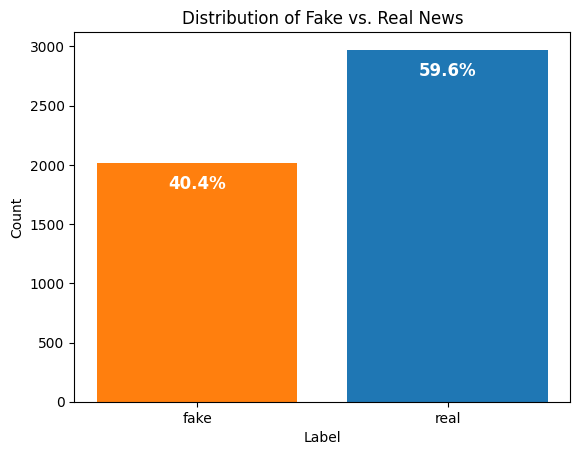

In [110]:
x = ["fake", "real"]
y = [fakenews_df[fakenews_df.label == "fake"].shape[0],
     fakenews_df[fakenews_df.label == "real"].shape[0]]
fig, ax = plt.subplots()
bars = ax.bar(x, y, color = ["tab:orange", "tab:blue"])
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Distribution of Fake vs. Real News")
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        perc_str = str(round(100 * height / len(fakenews_df), 1)) + "%"
        ax.text(bar.get_x() + bar.get_width()/2., height - 100,
                '%s' % perc_str, ha = "center", va = "top",
                color = "white", weight = "bold", size = 12)
autolabel(bars)
plt.show()

There are about 1.5 times as many observations labeled real news as there are observations labeled fake news in the dataset. This is only a slight class imbalance and should not affect the predictive power of the models we develop later.

A lot of the data is regarding celebrities, so we want to perform Named Entity Recognition (NER) to aid our analysis. In order to perform NER, we first preprocess the text by splitting it into sentences and tagging the words in each sentence according to their most likely parts of speech.

In [111]:
def ne_preprocess(doc):
    sents = nltk.sent_tokenize(doc)
    sents = [nltk.word_tokenize(sent) for sent in sents]
    sents = [nltk.pos_tag(sent) for sent in sents]
    return sents
def tag_sentences(df, col):
    text = df.loc[:, col]
    df["tagged_sents"] = df.loc[:, col].apply(ne_preprocess)
tag_sentences(fakenews_df, "text")

Then we perform NER on the tagged sentences and store any recognized entities labeled "PERSON" as our first features.

In [112]:
def get_ne_leaves(tree, label):
    return [t.leaves() for t in tree.subtrees(lambda s: s.label() == label)]
def ne_recognize(tagged_sents, labels = ["PERSON"]):
    entities = {}
    for lab in labels:
        for sent in tagged_sents:
            ne_tree = nltk.ne_chunk(sent, binary=False)
            ne_leaves = get_ne_leaves(ne_tree, lab)
            if len(ne_leaves) > 0:
                for leaf in ne_leaves:
                    name = " ".join([partial for partial, pos in leaf])
                    entities[name] = lab
    return entities
def ne_extract(df, col):
    df["named_entities"] = df.loc[:, col].apply(ne_recognize)
ne_extract(fakenews_df, "tagged_sents")
def extract_features(df):
    features_list = []
    for x in df["named_entities"]:
        features = {}
        for person in x.keys():
            features["mentions({})".format(person)] = True
        features_list.append(features)
    return features_list
fakenews_df["features"] = extract_features(fakenews_df)

NER isn't perfect, so it incorrectly labels many non-person entities as people. We are also only interested in celebrities that appear frequently in the dataset. So we look for named entities that occur in 20 or more observations and contain at least one space character (indicating the string is likely composed of a first name and a last name) in hopes of both getting rid of many mislabeled entities and reducing the number of named entity features.

In [113]:
mentions = fakenews_df["features"].to_list()
mentions = [x for d in mentions for x in list(d)]
mentions = {key: mentions.count(key) for key in set(mentions)}
mentions = dict(sorted(mentions.items(), key = lambda x:x[1], reverse = True))
mentions = {key: val for key, val in mentions.items() if re.match(".*\s.*", key)}
mentions = {key: val for key, val in mentions.items() if val >= 20}
n = len(mentions)
print(f"\nThere are {n} named entities recognized as people in the dataset that are formatted in a style similar to <first_name>...<last_name>.\n")
print("The 10 most frequent of these entities are:\n")
wrapped = tw.fill(str(list(mentions.items())[:10]))
print(wrapped)


There are 158 named entities recognized as people in the dataset that are formatted in a style similar to <first_name>...<last_name>.

The 10 most frequent of these entities are:

[('mentions(Donald Trump)', 238), ('mentions(Brad Pitt)', 183),
('mentions(Meghan Markle)', 169), ('mentions(Kanye West)', 157),
('mentions(Kim Kardashian)', 154), ('mentions(Justin Bieber)', 146),
('mentions(Angelina Jolie)', 129), ('mentions(Selena Gomez)', 122),
('mentions(Us Weekly)', 120), ('mentions(Jennifer Aniston)', 120)]


We remove any less frequent named entities and those that don't look like they are composed of a first name and a last name from our features.

In [114]:
acceptable = list(mentions.keys())
def remove_features(row, keep = []):
    d = row["features"]
    copy = d.copy()
    for k in d.keys():
        if k not in keep:
            del copy[k]
    return copy
fakenews_df["features"] = fakenews_df.apply(remove_features, keep = acceptable, axis = 1)

Now that we have the named entity features we want to use, we turn our attention to the rest of the text in the documents, first eliminating the text we've already identified as named entities and then any stopwords.

In [115]:
stop_words = set(stopwords.words('english'))
def remove_entities_and_stopwords(text, entities):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in entities and token.lower() not in stop_words]
    return " ".join(filtered_tokens)
# Applying the removal function
fakenews_df['cleaned_text'] = fakenews_df.apply(lambda row: remove_entities_and_stopwords(row['text'], row['named_entities'].keys()), axis=1)

We take a look at the most frequent words in the remaining text.

In [116]:
tokens = fakenews_df['cleaned_text'].apply(nltk.word_tokenize)
fdist = nltk.FreqDist(w.lower() for entry in tokens for w in entry if w.isalpha())
fdist = dict(sorted(fdist.items(), key = lambda x:x[1], reverse = True))
print("\nThe 100 most frequent words in the remaining text are:\n")
wrapped = tw.fill(str(list(fdist.items())[:100]))
print(wrapped)


The 100 most frequent words in the remaining text are:

[('said', 8598), ('one', 7878), ('new', 7060), ('also', 6823),
('time', 6261), ('first', 6256), ('like', 6141), ('people', 5826),
('would', 5709), ('show', 4904), ('two', 4646), ('get', 4367),
('years', 4086), ('know', 3937), ('year', 3761), ('going', 3692),
('back', 3692), ('told', 3666), ('film', 3643), ('family', 3619),
('us', 3589), ('love', 3428), ('may', 3365), ('think', 3362), ('life',
3340), ('made', 3300), ('season', 3105), ('day', 3095), ('best',
3089), ('news', 2992), ('last', 2959), ('want', 2915), ('together',
2821), ('even', 2805), ('star', 2722), ('says', 2694), ('really',
2681), ('make', 2643), ('could', 2639), ('series', 2602), ('way',
2577), ('see', 2536), ('world', 2534), ('well', 2514), ('since',
2495), ('got', 2476), ('much', 2417), ('couple', 2335), ('still',
2324), ('later', 2276), ('right', 2269), ('million', 2256), ('many',
2253), ('go', 2246), ('relationship', 2240), ('video', 2233),
('things', 2208), ('

We limit the words we will use for "has(word)" features to the 2500 most frequent ones.

In [117]:
acceptable = list(fdist)[:2500]

We also generate features for the counts of non-alphanumeric characters, numeric characters, and total characters within the text.

In [118]:
def text_features(text, keep):
    non_alnum = sum(not char.isalnum() for char in text)
    numeric = sum(char.isdigit() for char in text)
    total_chars = len(text)
    tokenized = nltk.word_tokenize(text)
    word_features = {f'has({word})': True for word in tokenized if word in keep}
    return {'count(non-alphanumeric)': non_alnum, 'count(numeric)': numeric, 'count(characters)': total_chars, **word_features}

# Apply the feature extraction
fakenews_df['additional_features'] = fakenews_df['cleaned_text'].apply(text_features, keep = acceptable)

We combine the features we have developed and refined.

In [119]:
def combine_features(row):
    combined = row["features"]
    combined.update(row["additional_features"])
    return combined
fakenews_df['combined_features'] = fakenews_df.apply(combine_features, axis=1)

We train our models.

In [120]:
# Prepare the data
X = list(fakenews_df['combined_features'])
y = fakenews_df['label'].apply(lambda x: 1 if x == 'fake' else 0)

# Vectorizing the feature dictionaries
vec = DictVectorizer()
X_vec = vec.fit_transform(X).toarray()

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.25, random_state=42)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       738
           1       0.73      0.43      0.54       509

    accuracy                           0.70      1247
   macro avg       0.71      0.66      0.66      1247
weighted avg       0.71      0.70      0.68      1247

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       738
           1       0.80      0.54      0.65       509

    accuracy                           0.76      1247
   macro avg       0.77      0.72      0.73      1247
weighted avg       0.76      0.76      0.75      1247



The Random Forest model is more accurate than the Naive Bayes model. The 20 most important features in the Random Forest model are:

In [122]:
# Extract feature importance estimates from the RFC
feature_imp = rf_model.feature_importances_

# Get feature names from the DictVectorizer
feature_names = vec.get_feature_names_out()

# Combine names and importances
feature_imp = zip(feature_names, feature_imp)
feature_imp = sorted(feature_imp, key=lambda x: x[1], reverse=True)

# Print top N most important features
for feature, importance in feature_imp[:20]:
    print(f"{feature}: {importance}")


has(source): 0.023274238734996476
count(characters): 0.0184286057992747
count(non-alphanumeric): 0.016727609704304564
has(insider): 0.014942363212209393
count(numeric): 0.00790281614333773
has(notifications): 0.0071116997538740135
mentions(Brad Pitt): 0.006492924315817956
has(push): 0.005564407166862459
has(features): 0.005265713070738007
has(told): 0.0039214601620673325
mentions(Angelina Jolie): 0.003772217342255993
has(season): 0.003645701175037748
has(reportedly): 0.0031128517847286872
mentions(Donald Trump): 0.0030616590253297023
has(divorce): 0.002856426778514583
has(romance): 0.0028165505323785446
has(series): 0.002816431626662644
has(first): 0.002724099026603759
has(reports): 0.0026248644426071
has(rumors): 0.0025741089538041995


As expected, knowing whether particular celebrities were mentioned in an observation was important in predicting fake news observations. Brad Pitt, Angelina Jolie, and Donald Trump all stood out.